In [1]:
from glob2 import glob

In [2]:
from email.parser import Parser

In [3]:
import os

In [4]:
def extractEmailBody(filename):
    with open(filename, 'r') as fin:
        mail = fin.readlines()
        mail = ''.join(mail)
        msg = Parser().parsestr(mail)
        return msg.get_payload()

In [5]:
def removeQuotedText(body):
    # Remove everything after 'Original Message'
    cutIdx = body.find('-----Original Message')
    if cutIdx!=-1:
        body = body[:cutIdx]
    return body

In [6]:
def saveEmailBody(filename, body):
    dirname = os.path.dirname(filename)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    with open(filename, 'w') as fout:
        fout.write(body)

In [7]:
basedir = 'enron_mail'
savedir = 'enron_mail_clean'
docs = glob(basedir + '/**/*.')

In [20]:
for doc in docs:
    try:
        body = extractEmailBody(doc)
        body = removeQuotedText(body)
        newDoc = doc.replace(basedir, savedir)
        saveEmailBody(newDoc, body)
    except Exception as e:
        print "Error with doc: ", doc

In [8]:
docs = glob(savedir + '/**/*.')

In [9]:
from nltk.tokenize import RegexpTokenizer

In [27]:
vocab = set()

tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

for doc in docs:
    with open(doc, 'r') as fin:
        mail = fin.readlines()
        mail = ''.join(mail)
        tokens = tokenizer.tokenize(mail)
        tokens = [ t.lower() for t in tokens ]
        vocab.update(tokens)

In [10]:
import gensim

In [29]:
def docList(docs):
    for doc in docs:
        with open(doc, 'r') as fin:
            mail = fin.readlines()
            mail = ''.join(mail)
            tokens = tokenizer.tokenize(mail)
            tokens = [ t.lower() for t in tokens ]
            yield tokens

In [51]:
dic = gensim.corpora.Dictionary.from_documents(docList(docs))

In [54]:
dic.save('enron_vocab.gensim.dic')

In [63]:
dic = gensim.corpora.Dictionary.load('enron_vocab.gensim.dic')

In [74]:
# Load
# dic = gensim.corpora.Dictionary.load('enron_vocab.gensim.dic')

# Remove ignore tokens: 
# dic.filter_tokens(bad_ids=[277, 339])

In [59]:
# Notice that texcatlipocatl does not appear in the corpus
email = 'hello all this is a sample email from texcatlipocatl'.split()
emailIds = dic.doc2bow(email)
for id,count in emailIds:
    print 'Word  %-10s (id=%6d) appears %6d times in corpus'%('"'+dic[id]+'"',id,dic.dfs[id])

Word  "from"     (id=   111) appears 194178 times in corpus
Word  "a"        (id=   129) appears 294818 times in corpus
Word  "this"     (id=   148) appears 245405 times in corpus
Word  "all"      (id=   187) appears 123167 times in corpus
Word  "is"       (id=   277) appears 273785 times in corpus
Word  "email"    (id=   763) appears  53633 times in corpus
Word  "sample"   (id=   912) appears   2641 times in corpus
Word  "hello"    (id= 13515) appears   6611 times in corpus


In [66]:
stopwords = 'all this is a from '.split()
stopwordIds = [ id for id,count in dic.doc2bow(stopwords) ]
dic.filter_tokens(bad_ids=stopwordIds)

email = 'hello all this is a sample email from texcatlipocatl'.split()
emailIds = dic.doc2bow(email)
for id,count in emailIds:
    print 'Word  %-10s (id=%6d) appears %6d times in corpus'%('"'+dic[id]+'"',id,dic.dfs[id])

Word  "email"    (id= 17171) appears  53633 times in corpus
Word  "sample"   (id=350196) appears   2641 times in corpus
Word  "hello"    (id=830234) appears   6611 times in corpus


In [11]:
dic = gensim.corpora.Dictionary.load('enron_vocab.gensim.dic')

In [25]:
dic.dfs[0], dic.dfs[343881]

(49726, 4)

In [29]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


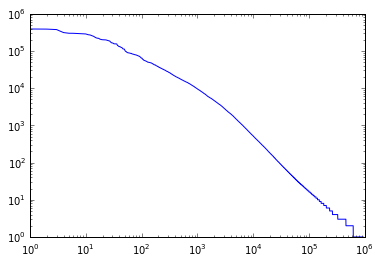

In [40]:
x = dic.dfs.values()
x = sorted(x)
x = x[::-1]
loglog(x)

In [21]:
# Email stop quoted text markers

# -----Original Message-----
# "James Robinson (CES)" <cypress@neosoft.com> on 08/05/99 04:31:16 PM
# ---------------------- Forwarded by Louis Soldano/ET&S/Enron on 06/02/99 01:12 PM ---------------------------
# > 
# msg = Parser().parsestr(msg).get_payload() N times

# Outline
Say we have $N=10$ topics (although this is arbitrary and I don't like it). For each document (email) we can calculate which topics make it up and on what proportion

 - Email 1: 10% Topic 1,  5% Topic 2, 15% Topic 3...
 - Email 2:  5% Topic 1, 25% Topic 2,  7% Topic 3...
 - Email 3: 30% Topic 1, 15% Topic 2,  5% Topic 3...
 - etc

Using this, can we compute a distance between documents?

Also, keep in mind that each topic provides a probability distribution of words. Meaning that:

 - Topic 1: 5% "dog", 10% "cat", 7% "wolf"
 - Topic 2: 7% "car", 20% "train", 1% "boat"
 - Topic 3: 8% "dog", 15% "house", 13% "tree"

If we can calculate the distance between two documents (using cosine similarity, for instance) we can build a distance matrix from every email to every other email. We can use such a distance matrix to construct a 'map' where we place documents in a 2D space, clustering together documents which are similar to other documents -- this is easy using MDS.